In [22]:
#############################################
## MATPLOTLIB FEATURES
%matplotlib inline
import matplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
font = {'weight' : 'bold','size'   : 22}
mpl.rc('font', **font)
mpl.rc('font',   size=209)  #set defaults so that the plots are readable
mpl.rc('axes',   titlesize=20)
mpl.rc('axes',   labelsize=20)
mpl.rc('xtick',  labelsize=20)
mpl.rc('ytick',  labelsize=20)
mpl.rc('legend', fontsize =20)
mpl.rc('figure', titlesize=20)
mpl.rc('text',   usetex=True)
## FURTHER MATPLOTLIB FEATURES
#import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
colors = ['black','darkgrey', '#0000ff', '#ff0000', '#0000FF',  '#FF0000', '#069AF3', '#00008B','#C79FEF','#DC143C','#C875C4','#9A0EEA','darkorange','#C79FEF','#7E1E9C','silver','#FF7F50','#FC5A50',
          '#FFA500','#F97306','#FFD700','#DDA0DD','#00008B','#069AF3','#0000FF','#00FFFF','#13EAC9','#7FFFD4','#04D8B2','#40E0D0']
my_cmap = ListedColormap(colors, name="my_cmap")
font_dict = {'family': 'serif', 'color':  None,  'weight': 'bold','size': 30}
#############################################
import os,sys,time,platform
from copy import deepcopy as dcopy
import numpy as np
from scipy import integrate
import healpy as hp
import camb
from camb import model, initialpower
#############################################
#PATH TO SCRIPTS FOLDER
path = '/data/AMARINS/CMBWLxHI-CODES/scripts/'
sys.path.insert(1, path)
import cross_functions_theory      as cxft

In [2]:
def THI_factor_constants():
    G_chbar  = 6.70883e-39 #(GeV/c2)-2
    G_kg     = 6.67430e-11 #N m2/kg2 #m3/kg/s2
    hP_kg    = 6.62607015e-34 #m2 kg s
    kB_kg    = 1.380649e-23 #m2 kg s-2 K-1
    c        = 299792458 #m s-1
    mP       = 1.67262192e-24 #g
    mHI_u    = 1.00784 #u
    u_g      = 1.66054e-24 #g
    A10      = 2.85e-15 #s-1
    H0       = 67.4 #km/s/Mpc.
    Mpc_m    = 3.0857e22 # m
    factor   = 9/(256*np.pi**2)
    nu_MHz   = 1420.405751768 #MHz
    N        = 1 #kg m/s2

    kB     = kB_kg*1e3
    hP     = hP_kg*1e3
    G      = G_kg/1e3
    mHI    = mHI_u*u_g
    H0_ms  = H0*(1e3/Mpc_m)
    nu     = nu_MHz*1e6
    nu2    = nu**2
    c3     = c**3
    h      = H0/100. #admensional 
    fac   = factor*(hP*c3*A10*H0_ms)/(G*kB*nu2*mHI)
    fac_h = factor*(hP*c3*A10)/(G*kB*nu2*mHI)*(100*(1e3/Mpc_m))
    return fac_h

def hi_brightness_temperature(camb_params=None, camb_results=None, z=None, model = None):
    fact = (1+z)**2/(camb_results.hubble_parameter(z)/camb_params.H0)
    oHI  = omegaHI_biasHI(model=model,z=z)['omegaHI']*camb_params.h
    fact = fact*188.8#(THI_factor_constants()/1e-3)
    return fact*oHI #mK

In [3]:
def omegaHI_biasHI(model="jiajun",z=None):
    if model=="jiajun": #valido para z < 1.#Zhang et al 2022
        return {"omegaHI":{"HOD":2.7e-4 + 1e-4*z - 8e-5*z**2,
                          "HAM":2.5e-4 - 4e-5*z - 7e-5*z**2}
               }
    if model=="padmanabhan":#padmanabhan 2015
        z = np.array(  [0.000, 0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000, 2.250, 2.500, 2.750, 3.000, 3.250, 3.400])
        oHI = np.array([3.344, 3.443, 4.523, 4.648, 4.710, 4.804, 4.766, 4.804, 4.936, 5.008, 4.750, 5.471, 5.541, 5.756, 5.971])
        bHI = np.array([0.703, 0.972, 1.026, 0.935, 1.005, 1.005, 1.049, 1.099, 1.101, 1.160, 1.261, 1.409, 1.329, 1.498, 1.802])        
        return {"z":z, "omegaHI":oHI, "bias":bHI}
    if model=="cunnington":#cunnington2019
        return {"omegaHI":0.00048 + 0.00039*z - 0.000065*z**2}
    if model=="irfan":#Irfan2021 baseado em bull2015 #o mesmo que IRFAN2021
        omegaHI_0 = 4.86e-4 #Irfan2021
        biasHI_0 = 0.677105 #Irfan2021
        return {"omegaHI": (omegaHI_0/4.86)*(4.8304 + 3.8856*z - 0.65119*z**2) ,
                "biasHI" : (biasHI_0/0.677105)*(0.66655 + 0.17765*z + 0.050223*z**2)}
    if model=="crighton":#carucci2020
        omegaHI_0 = 4e-4 #Irfan2021
        biasHI_0  = 0.3 #Irfan2021        
        return {"omegaHI": omegaHI_0*(1+z)**(0.6) ,
                "biasHI" : biasHI_0*(1+z)+0.6}
    else:
        return {"omegaHI": 4.86e-4,
                "biasHI" : 1}        

In [4]:
params = { 'H0'   : 67.5,
           'ombh2': 0.022,
           'omch2': 0.122,
           'ns'   : 0.965,
           'z'    : [0,1],
           'kmax' : 3,
           'minkh': 1e-4,
           'maxkh': 1,
           'npoints': 200}          


pars = camb.CAMBparams()
pars.set_cosmology(H0=params['H0'], ombh2=params['ombh2'], omch2=params['omch2'])
pars.InitPower.set_params(ns=params['ns'])
pars.set_matter_power(redshifts=params['z'], kmax=params['kmax'])
results   = camb.get_results(pars)
pk_interp = camb.get_matter_power_interpolator(pars, 
                                               nonlinear=False, hubble_units=False, k_hunit=False, 
                                               kmax=params['kmax'], zmax=params['z'][-1])

Note: redshifts have been re-sorted (earliest first)


In [5]:
def window_1(z=None, zmin=None, zmax=None):
    if (z>=zmin)*(z<=zmax): return 1/(zmax-zmin)
    else: return 0
    
def chi_vec(camb_results=None): #radial comovel distance
    from scipy import interpolate
    zv         = np.linspace(0,1200)
    rv         = camb_results.comoving_radial_distance(zv)
    z_chi      = interpolate.interp1d(rv, zv, kind='linear') #function
    z_star     = camb_results.get_derived_params()['zstar']
    chi_star   = camb_results.comoving_radial_distance(z_star)
    #zs         = results.redshift_at_comoving_radial_distance(np.linspace(0,chi_star,nz))
    z_chi_camb = lambda y: results.redshift_at_comoving_radial_distance(y)    
    return {'zvec':zv, 'chivec':rv, 'z_chi': z_chi, 'z_chi_camb':z_chi_camb, 'z_star':z_star, 'chi_star':chi_star}

def kernel_cmb_z(camb_params=None, camb_results=None, z=None):
    c        = 299792458/1e3
    fact     = 1.5*camb_params.omegam*camb_params.H0**2/c/camb_results.hubble_parameter(z)
    chi_star = chi_vec(camb_results)['chi_star']
    chi_z    = camb_results.comoving_radial_distance(z)
    return fact*(1+z)*chi_z*(chi_star-chi_z)/chi_star

def kernel_cmb_chi(camb_params=None, camb_results=None, chi=None):
    c        = 299792458/1e3
    fact     = 1.5*camb_params.omegam*camb_params.H0**2/(c**2)
    chi_dict = chi_vec(camb_results)
    chi_star = chi_dict['chi_star']
    return fact*(1+chi_dict['z_chi'](chi))*chi*(chi_star-chi)/chi_star


def kernel_hi(camb_params=None, camb_results=None, z=None, zmin = None, zmax=None, model=None):
    w1     = window_1(z=z, zmin=zmin, zmax=zmax)
    if not w1: return 0
    THI = hi_brightness_temperature(camb_params=camb_params, camb_results=camb_results, z=z)
    bHI    = omegaHI_biasHI(model=model,z=z)['biasHI']
    return bHI*THI*w1
    

def kernel_fields(params=None, camb_params=None, camb_results=None, z=None, type=None):#
    return 0

In [6]:
nu_HI  = 1420.405751768 #MHz
nu_vec = np.linspace(980,1260,30) 
z_BINGO = np.flip((nu_HI/nu_vec)-1)

nu_vec = np.linspace(350,1050,70) 
z_ska  = np.flip((nu_HI/nu_vec)-1)

In [7]:
Khi_all= np.array([])
Z_all= np.array([])
for i in np.arange(z_BINGO.size-1):
    zmin = z_BINGO[i]
    zmax = z_BINGO[i+1]
    z_range = np.linspace(zmin,zmax,100)
    for j,zj in enumerate(z_range):
        if not j: 
            khi = kernel_hi(camb_params=pars, camb_results=results, z=zj, zmin = zmin, zmax=zmax)
        else:
            khi = np.hstack((khi,kernel_hi(camb_params=pars, camb_results=results, z=zj, zmin = zmin, zmax=zmax)))
    Khi_all = np.hstack((Khi_all,khi))
    Z_all   = np.hstack((Z_all,z_range))
    if not i:
        Khi_dict = {str(i+1):khi}
        Z_dict   = {str(i+1):z_range}
    else:
        Khi_dict[str(i+1)] = khi 
        Z_dict[str(i+1)]   = z_range 

Khi_all_ska= np.array([])
Z_all_ska= np.array([])
for i in np.arange(z_ska.size-1):
    zmin = z_ska[i]
    zmax = z_ska[i+1]
    z_range = np.linspace(zmin,zmax,100)
    for j,zj in enumerate(z_range):
        if not j: 
            khi = kernel_hi(camb_params=pars, camb_results=results, z=zj, zmin = zmin, zmax=zmax)
        else:
            khi = np.hstack((khi,kernel_hi(camb_params=pars, camb_results=results, z=zj, zmin = zmin, zmax=zmax)))
    Khi_all_ska = np.hstack((Khi_all_ska,khi))
    Z_all_ska   = np.hstack((Z_all_ska,z_range))
    if not i:
        Khi_dict_ska = {str(i+1):khi}
        Z_dict_ska   = {str(i+1):z_range}
    else:
        Khi_dict_ska[str(i+1)] = khi 
        Z_dict_ska[str(i+1)]   = z_range 

In [8]:
for i,ikey in enumerate(Khi_dict.keys()):
    if not i : 
        khi_max = Khi_dict[ikey].max()
    else:
        if khi_max < Khi_dict[ikey].max():
            khi_max = Khi_dict[ikey].max()

Max at z=1.800


/tmp/ipykernel_438439/1085901674.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,3.1)


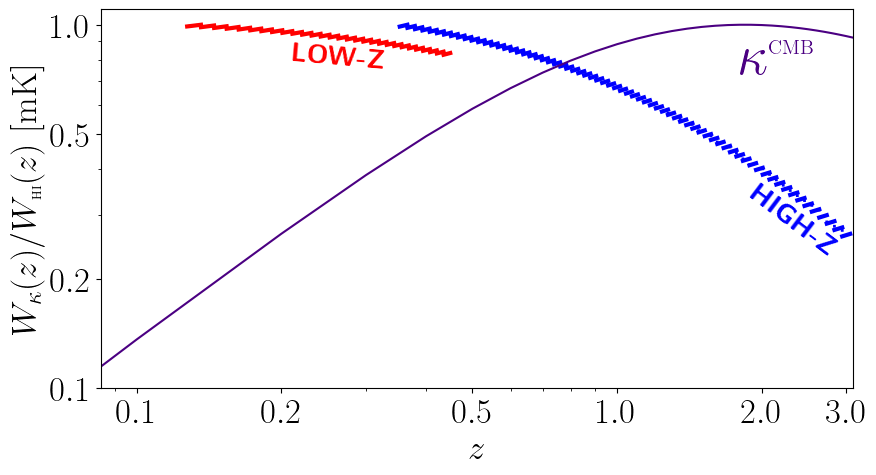

In [111]:
fig      = plt.figure()
grid     = plt.GridSpec(1,1,top=0.9,right=1.3,wspace=0.25)

ax = plt.subplot(grid[0,0])
zv = np.arange(0,z_ska.max()+0.1,0.1)
Kz = kernel_cmb_z(pars, results, z=zv)
z_at_max = zv[np.where(Kz==Kz.max())[0]][0]
print('Max at z={:.3f}'.format(z_at_max))     

z_dicts   = [Z_dict, Z_dict_ska]
z_alls    = [Z_all , Z_all_ska ]
khi_dicts = [Khi_dict, Khi_dict_ska]
khi_alls  = [Khi_all,Khi_all_ska]
colors1   = ['#ff0000', '#0000ff']
colors2   = ['#ff0000', '#0000ff']
for j, (z_dict, z_all, khi_dict, khi_all, icolor1, icolor2) in enumerate(zip(z_dicts, z_alls, khi_dicts, khi_alls, colors1, colors2)):
    ax = plt.subplot(grid[0,0])
    if 1:
        for i,ikey in enumerate(khi_dict.keys()):
            if not i : 
                khi_max = khi_dict[ikey].max()
            else:
                if khi_max < khi_dict[ikey].max():
                    khi_max = khi_dict[ikey].max()
    if j<1:
        ax.plot(z_all, khi_all/khi_max, linestyle='dotted', linewidth=2, color=icolor1)
        for i,iname in enumerate(khi_dict.keys()):
            ax.plot(z_dict[str(i+1)], khi_dict[str(i+1)]/khi_max, label=str(i), color=icolor2, linewidth=3)
    else:
        ax.plot(z_all, khi_all/khi_max, linestyle='dotted', linewidth=2, color=icolor1)
        for i,iname in enumerate(khi_dict.keys()):
            ax.plot(z_dict[str(i+1)], khi_dict[str(i+1)]/khi_max, label=str(i), color=icolor2, linewidth=3)        
        ax.plot(zv, Kz/Kz.max(), color='indigo')

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r"$z$", fontsize=25)
ax.set_ylabel(r"$W_{\kappa} (z) / W_{\textrm{\small HI}} (z)\ [\textrm{mK}]$", fontsize=25)       
ax.tick_params(axis='both', labelsize=25)        
ax.set_xlim(0,3.1)
cxticks = [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
ax.set_xticks(cxticks, [r'${}$'.format(s) for s in cxticks])
cyticks = [0.1,0.2, 0.5,1]
ax.set_yticks(cyticks, [r'${:.1f}$'.format(z) for z in cyticks])
font_dict = {'family': 'serif', 'color':  'indigo',  'weight': 'bold','size': 40}
ax.text(x=1.8, y=0.73,s=r'$\kappa^{\Large\textrm{CMB}}$', fontdict=font_dict)
font_dict['color']='#0000ff';font_dict['size']=20
ax.text(x=1.85, y=0.23,s=r'$\textbf{HIGH-Z}$', fontdict=font_dict,rotation=-37)
font_dict['color']='#ff0000';font_dict['size']=20
ax.text(x=0.21, y=0.76,s=r'$\textbf{LOW-Z}$', fontdict=font_dict,rotation=-5)
plt.savefig("/data/AMARINS/CMBWLxHI-CODES/images/{}_model2.png".format('kernels'), dpi=100, bbox_inches='tight');

In [18]:
nu_lowz   = np.linspace(980,1260,31)
lowz = cxft.get_zeff(numin =nu_lowz.min(), numax =nu_lowz.max(), nbands= nu_lowz.size-1, n_curves=nu_lowz.size-1)
#
nu_highz   = np.linspace(350,1050,71)
highz = cxft.get_zeff(numin =nu_highz.min(), numax =nu_highz.max(), nbands= nu_highz.size-1, n_curves=nu_highz.size-1)
#
highz

{'zeff': array([3.  , 2.89, 2.79, 2.69, 2.6 , 2.51, 2.42, 2.34, 2.27, 2.19, 2.12,
        2.05, 1.99, 1.93, 1.87, 1.81, 1.76, 1.71, 1.65, 1.61, 1.56, 1.51,
        1.47, 1.43, 1.39, 1.35, 1.31, 1.27, 1.24, 1.2 , 1.17, 1.14, 1.1 ,
        1.07, 1.04, 1.01, 0.99, 0.96, 0.93, 0.91, 0.88, 0.86, 0.83, 0.81,
        0.79, 0.76, 0.74, 0.72, 0.7 , 0.68, 0.66, 0.64, 0.62, 0.6 , 0.59,
        0.57, 0.55, 0.54, 0.52, 0.5 , 0.49, 0.47, 0.46, 0.44, 0.43, 0.41,
        0.4 , 0.39, 0.37, 0.36]),
 'bins': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69], dtype=int16),
 'nu_eff': array([ 355.,  365.,  375.,  385.,  395.,  405.,  415.,  425.,  435.,
         445.,  455.,  465.,  475.,  485.,  495.,  505.,  515.,  525.,
         535.,  545

'/data/AMARINS/CMBWLxHI-CODES/images/zeff_freq.png'

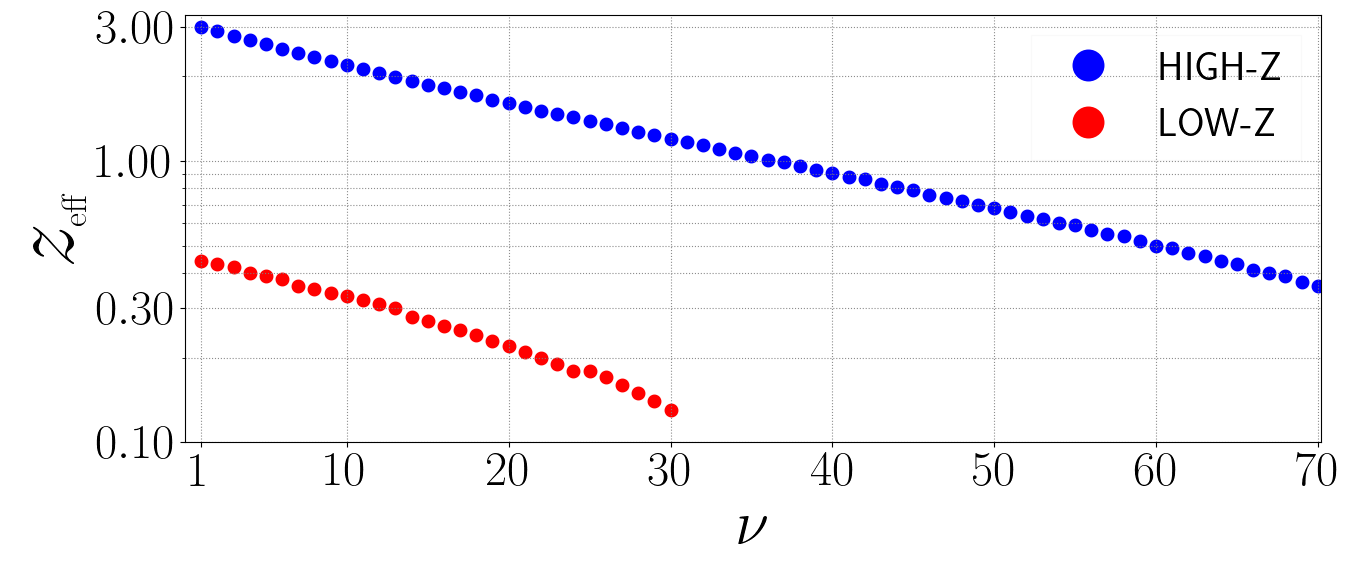

In [84]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.,right=1.9)
ax    = plt.subplot(grid[0,0])
#
cmap = plt.get_cmap(my_cmap)
###########################################################
###########################################################
ax.scatter(highz['bins']+1, highz['zeff'], color=cmap(2),lw=4, marker='o')
ax.scatter(lowz[ 'bins']+1, lowz['zeff' ], color=cmap(3),lw=4, marker='o')
###########################################################
ax.set_xscale('linear'); ax.set_yscale('log'); 
ax.set_xlim(0,70.2)
ax.set_ylim(0.1,3.3)
cyticks = [1e-1,3e-1,1e0,3e0]
cxticks = [1, 10, 20, 30, 40, 50, 60, 70]
ax.set_yticks(cyticks, [r'${:.2f}$'.format(z) for z in cyticks])
ax.set_xticks(cxticks, [r'${:.0f}$'.format(z) for z in cxticks])

ax.set_xlabel(r"$\nu$" , fontsize=45)
ax.set_ylabel(r"$z_{\Huge\textrm{eff}}$" , fontsize=65)    
ax.tick_params(axis='both', labelsize=35)
ax.grid(True, linestyle=':', color='grey', alpha=0.9, which="both",)
 
###########################################################
custom_lines = [Line2D([], [], color=my_cmap(2) , marker='o',
                       markersize=20, linestyle='None',markeredgewidth=3),
                Line2D([], [], color=my_cmap(3) , marker='o',
                       markersize=20, linestyle='None',markeredgewidth=3),
               ]

ax.legend(custom_lines, [r'HIGH-Z',r'LOW-Z'],
          ncols=1, fontsize=29, loc='upper right',framealpha=0.1, 
          fancybox=False,shadow=False,)#edgecolor='lightblue', 
###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '.'.join(('zeff_freq','png'))  )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

In [59]:
ax.grid?

Signature: ax.grid(visible=None, which='major', axis='both', **kwargs)
Docstring:
Configure the grid lines.

Parameters
----------
visible : bool or None, optional
    Whether to show the grid lines.  If any *kwargs* are supplied, it
    is assumed you want the grid on and *visible* will be set to True.

    If *visible* is *None* and there are no *kwargs*, this toggles the
    visibility of the lines.

which : {'major', 'minor', 'both'}, optional
    The grid lines to apply the changes on.

axis : {'both', 'x', 'y'}, optional
    The axis to apply the changes on.

**kwargs : `~matplotlib.lines.Line2D` properties
    Define the line properties of the grid, e.g.::

        grid(color='r', linestyle='-', linewidth=2)

    Valid keyword arguments are:

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    